In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append('../')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import anndata
from deblend.preprocessing import model_from_raw_counts

In [4]:
# Example raw count prep
subset_bulk = anndata.read_h5ad('../example_data/muscle_subset_bulk.h5ad')
subset = anndata.read_h5ad('../example_data/muscle_subset.h5ad')

# Raw counts prep
counts_by_onto_class = {}
for sc in subset:
    cell_onto_class = sc.obs['cell_ontology_class'][0]
    if cell_onto_class not in counts_by_onto_class:
        counts_by_onto_class[cell_onto_class] = np.empty((sc.X.shape[0], 0), dtype=np.float32)
    counts_by_onto_class[cell_onto_class] = np.hstack((counts_by_onto_class[cell_onto_class], sc.X.reshape((-1, 1))))

# Bulk prep
G = subset_bulk.n_vars
bulk_by_age = {}
for bulk in subset_bulk:
    age = bulk.obs['Age'][0]
    if age not in bulk_by_age:
        bulk_by_age[age] = []
    bulk_by_age[age].append(bulk.X.reshape(-1, 1))

bulk_labels = []
psis = np.empty((G, 0), dtype=np.float32)
for age in sorted(bulk_by_age.keys()):
    bulks = bulk_by_age[age]
    for i in range(len(bulks)):
        bulk_labels.append("{} months, subject {}".format(age, i))
        psis = np.hstack((psis, bulks[i]))

/usr/local/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


In [5]:
model, cleaned_psis = model_from_raw_counts(counts_by_onto_class, psis)

In [6]:
results = model.predict(cleaned_psis[:, :2], bulk_labels[:2])

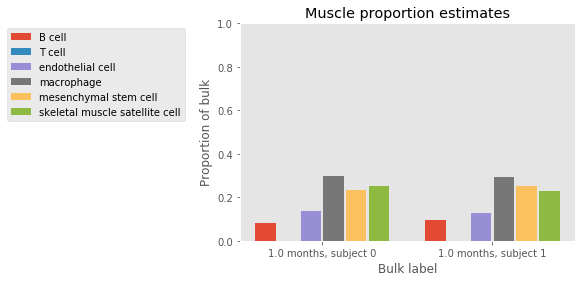

In [11]:
fig, ax = plt.subplots()
results.plot_proportions(ax)
ax.set_title("Muscle proportion estimates")
plt.show()